# Coronavirus 2020 - effectiveness of measures taken

- Please scroll down for plots.

- If you want to execute this, press SHIFT+RETURN to advance code cell to code cell.

- We use data from the files at   https://github.com/CSSEGISandData/COVID19/tree/master/csse_covid_19_data/csse_covid_19_time_series

- Acknowledgements:
  - great tutorials from https://www.youtube.com/channel/UCYO_jab_esuFRV4b17AJtAw
  - idea for loglog plot from https://www.youtube.com/user/minutephysics 
  - Johns Hopkins University for providing the data
  - Open Source and scientific computing community for the data tools



In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
# Alternative plotting backend for interative data exploration
# %matplotlib notebook

from coronavirus import overview

# If you want to edit the source in the notebook, try "%load coronavirus.py" 
# and comment out the import statement above.

# China, South Korea, Singapore

## China

Downloaded data: last data point 4/3/20 from https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
Downloaded data: last data point 4/3/20 from https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv


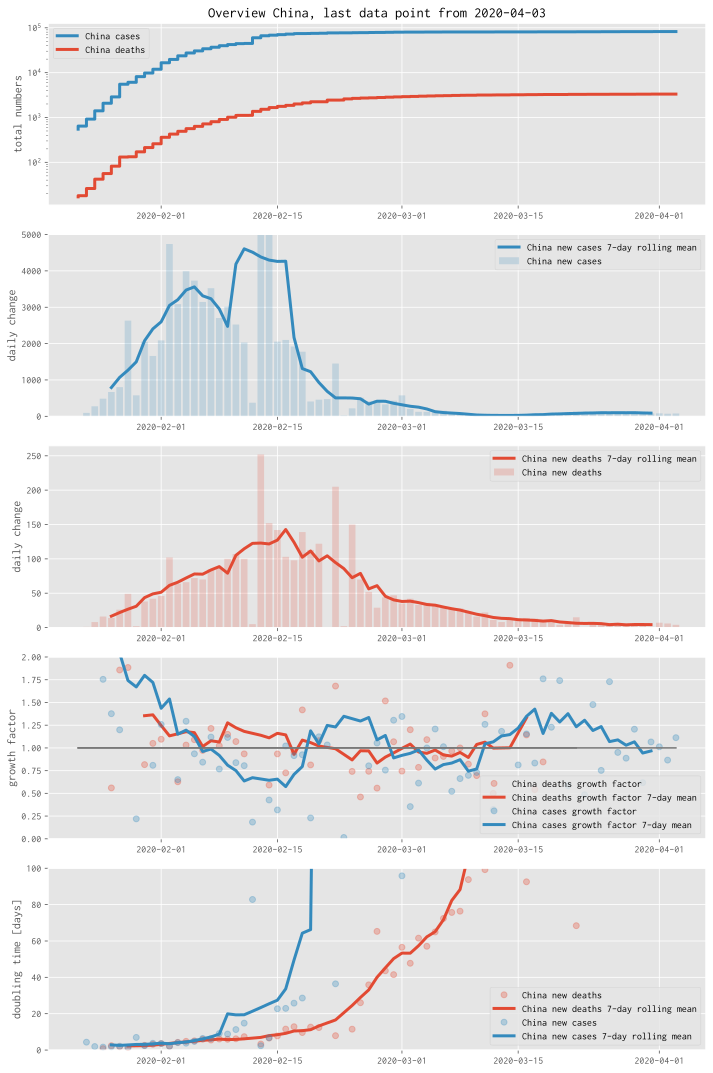

In [2]:
overview("China");

## South Korea

Can't plot doublingtime line for deaths in Korea, South due to too small numbers


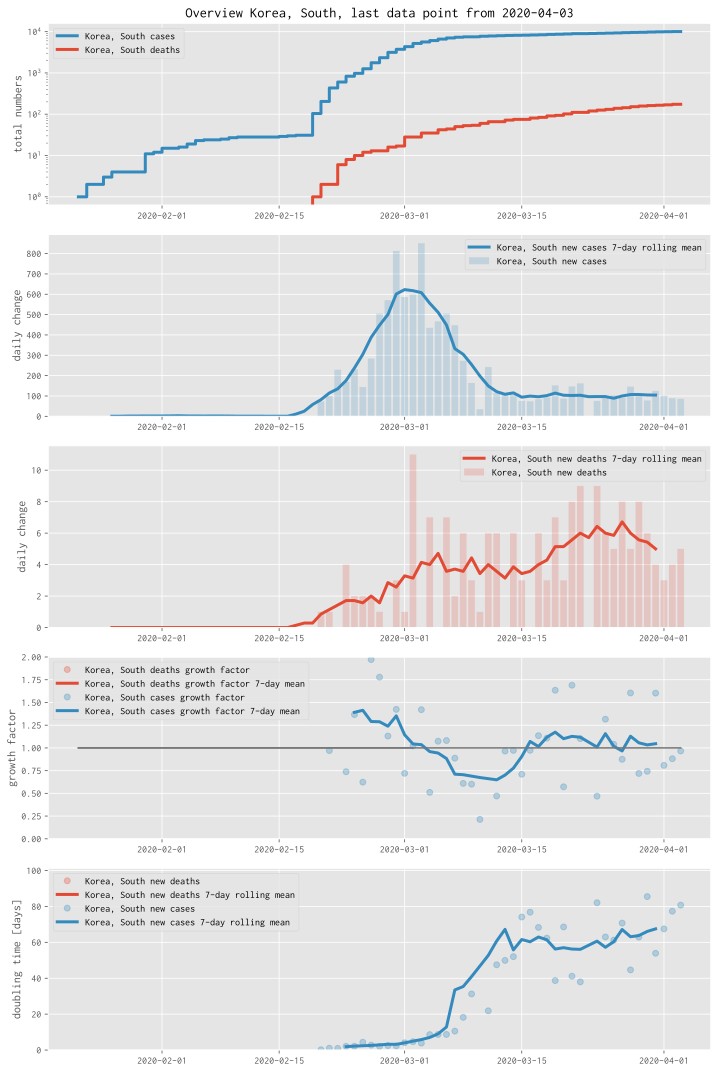

In [3]:
overview("Korea, South");

## Singapore

Can't plot doublingtime line for deaths in Singapore due to too small numbers


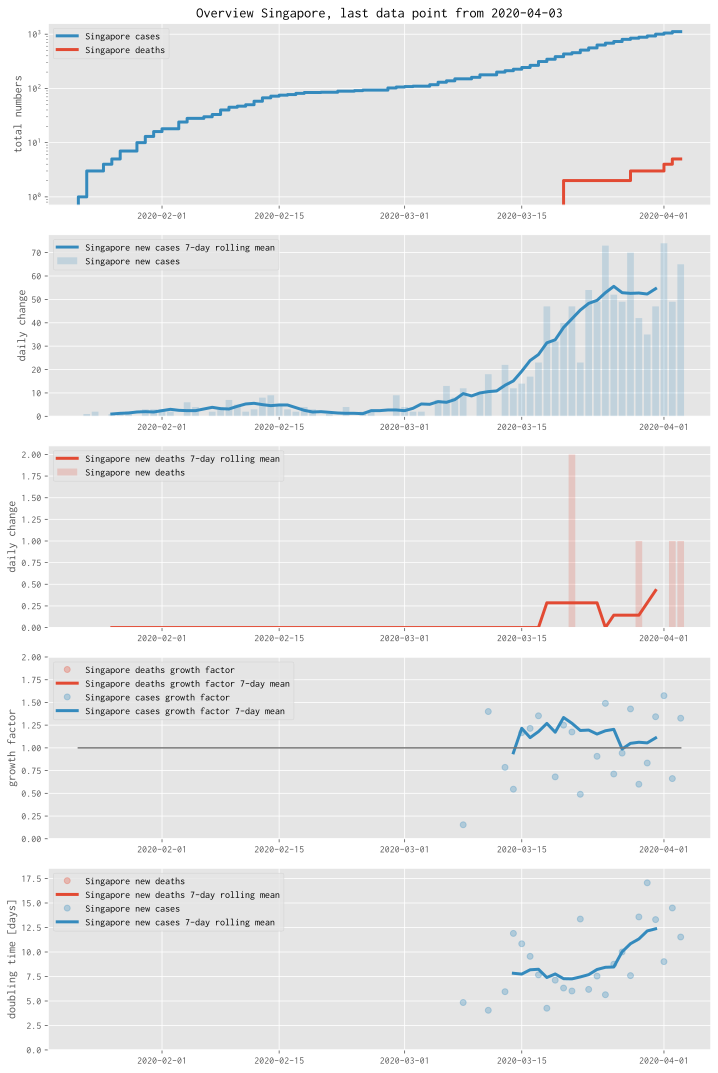

In [4]:
overview("Singapore");

# Countries with large numbers of reported infections

## United States

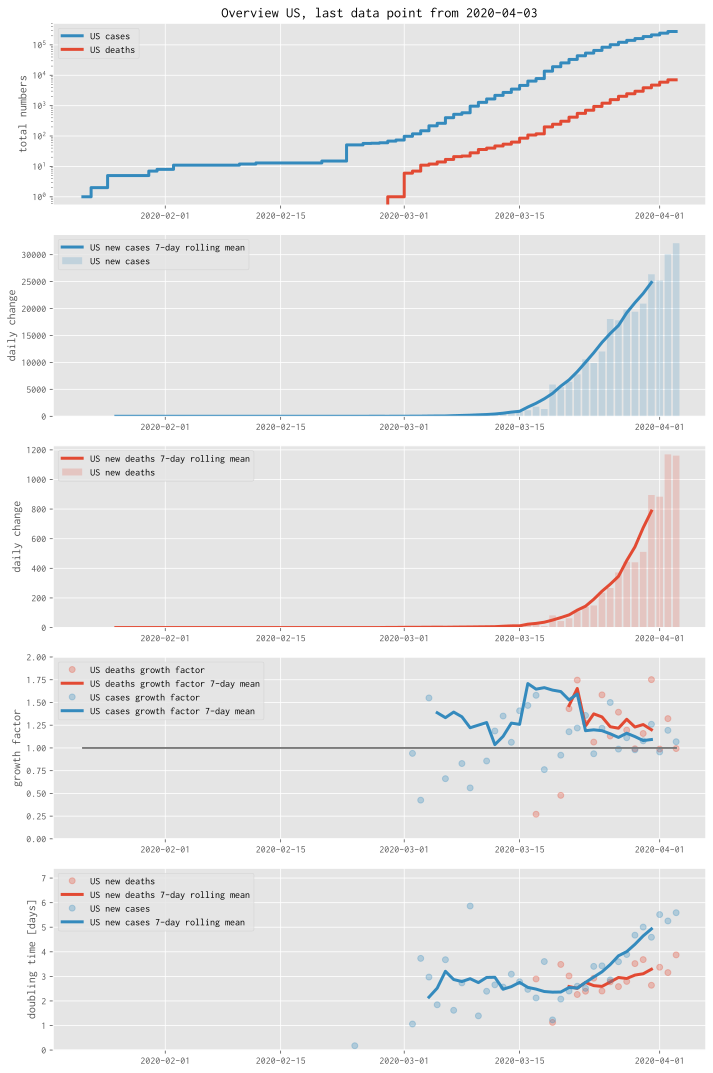

In [5]:
overview("US");

## Italy

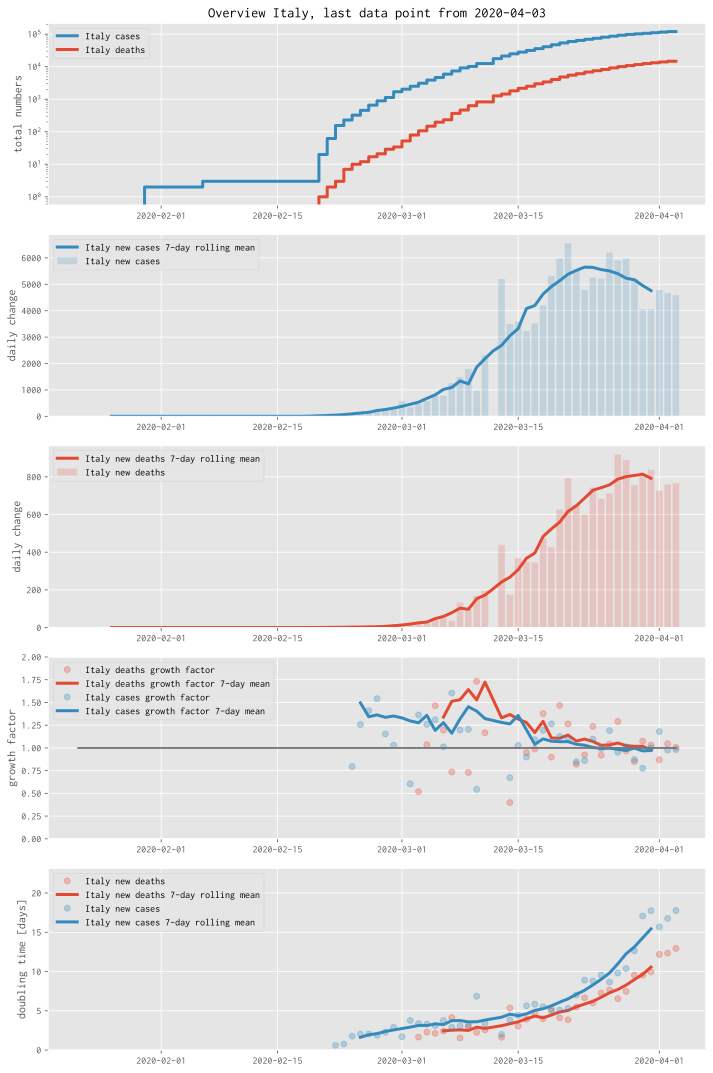

In [6]:
overview("Italy");

## Spain

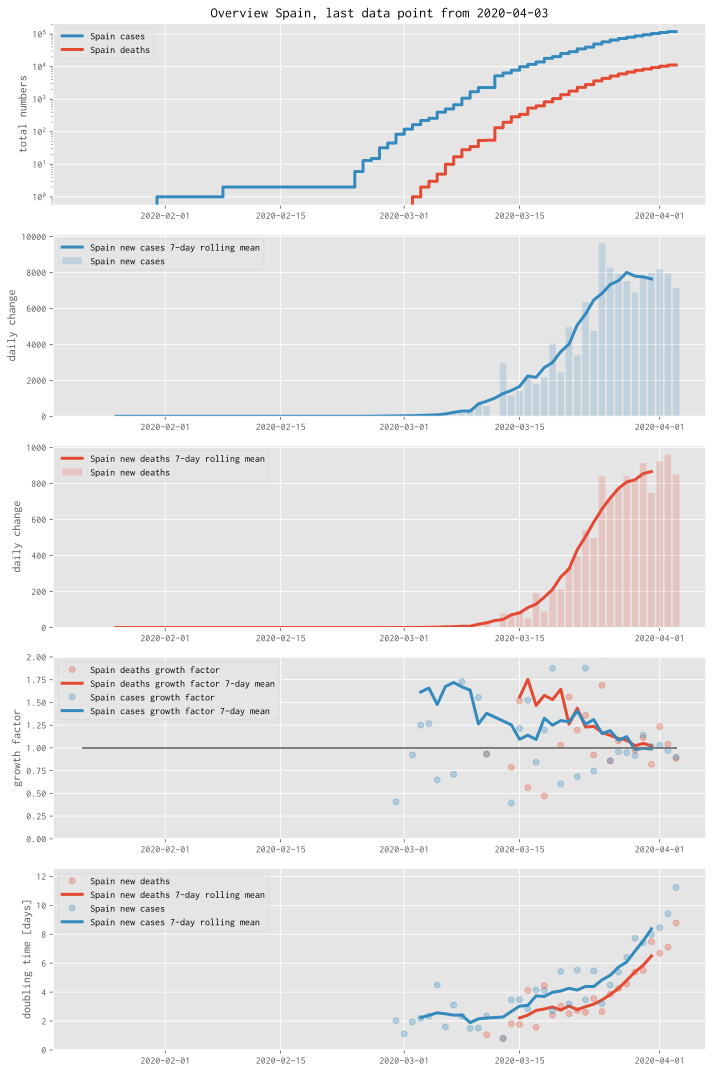

In [7]:
overview("Spain");

## Germany

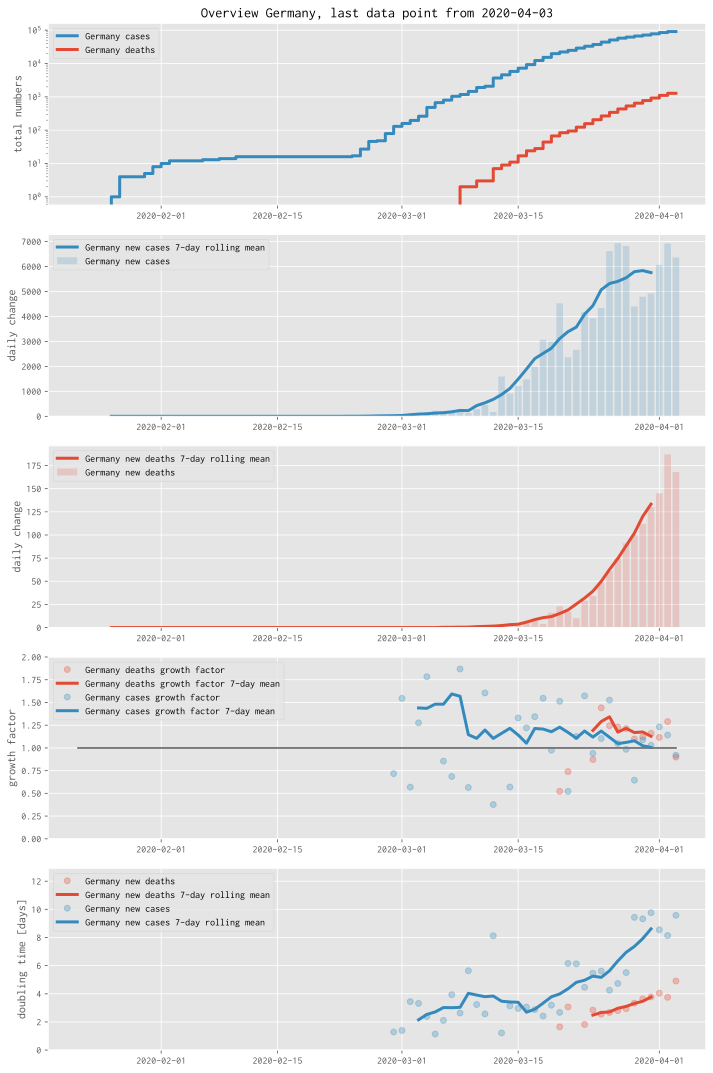

In [8]:
overview("Germany");

## France

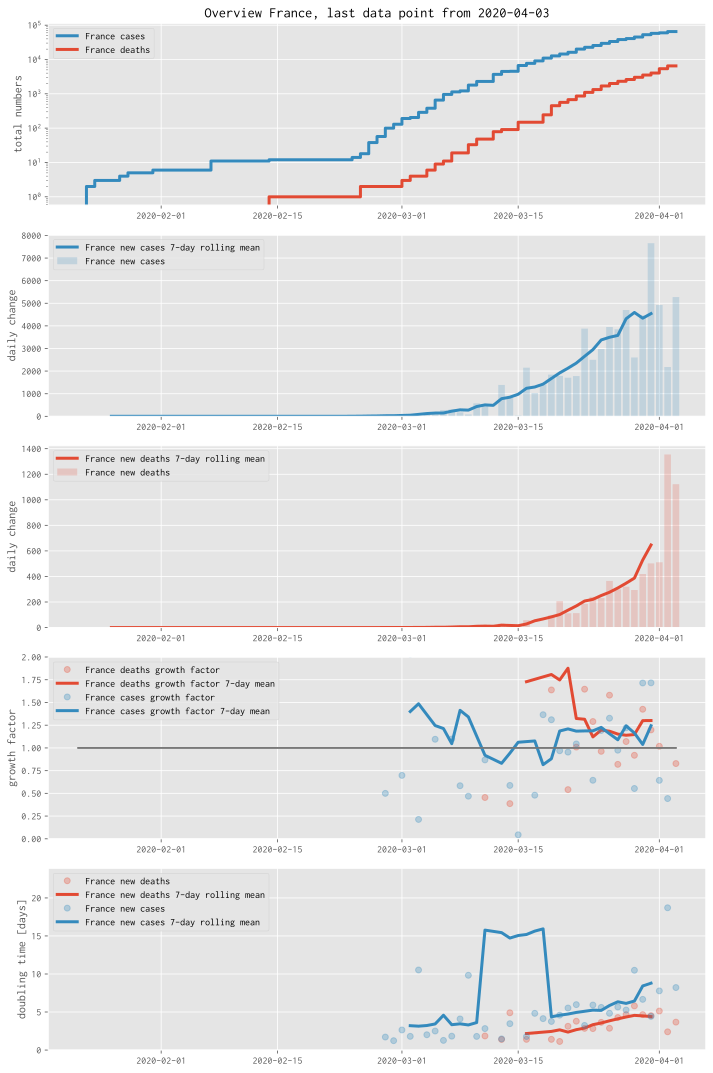

In [9]:
overview("France");

## Iran

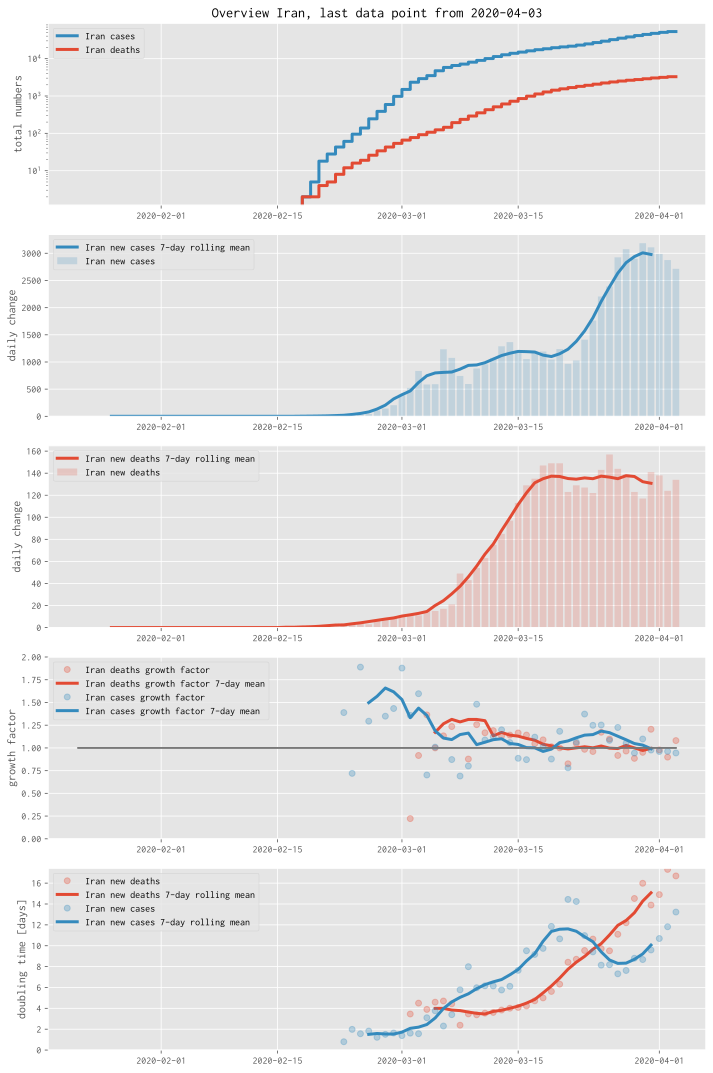

In [10]:
overview("Iran");

## United Kingdom

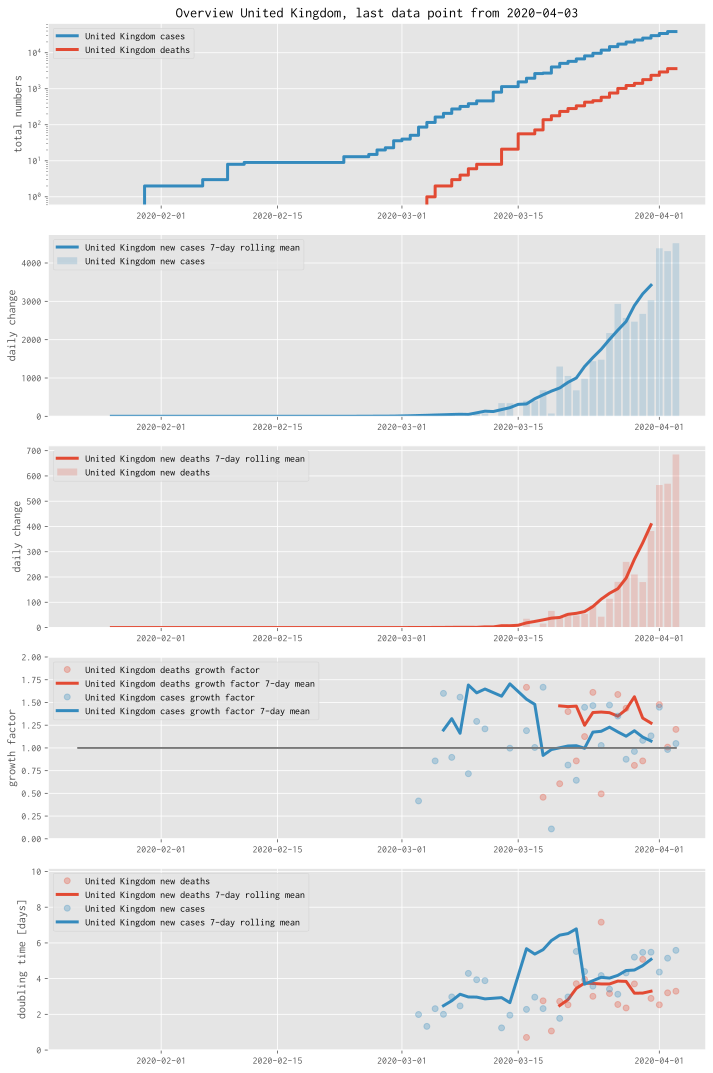

In [11]:
overview("United Kingdom");

## Switzerland

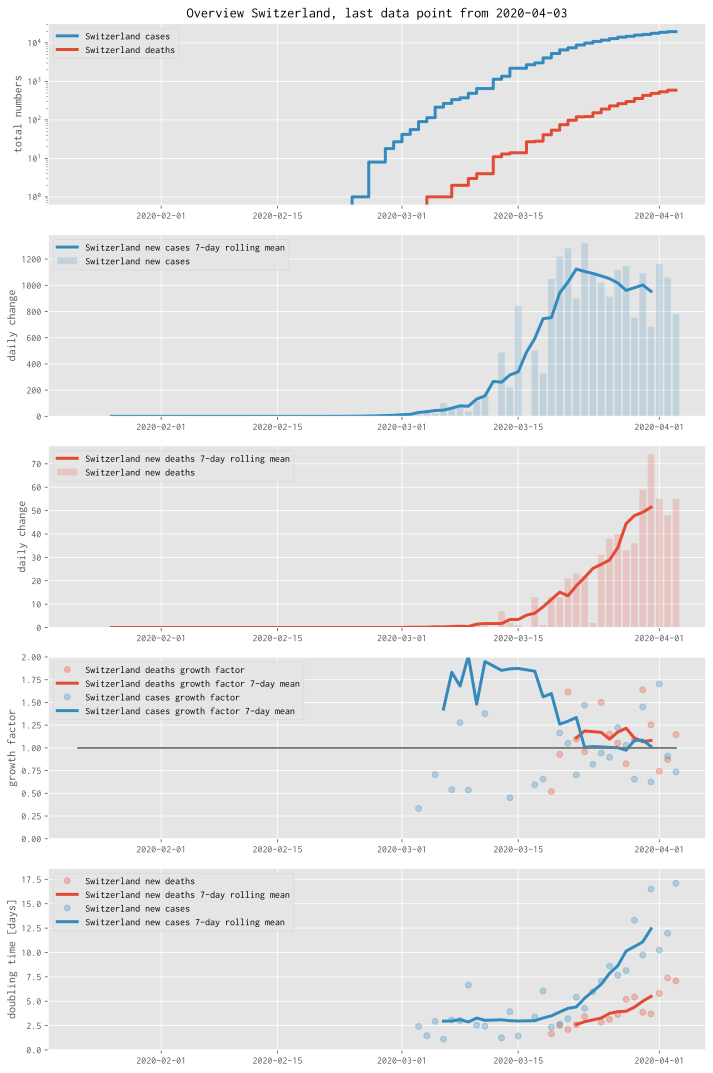

In [12]:
overview("Switzerland");

##  Austria

Can't plot doublingtime line for deaths in Austria due to too small numbers


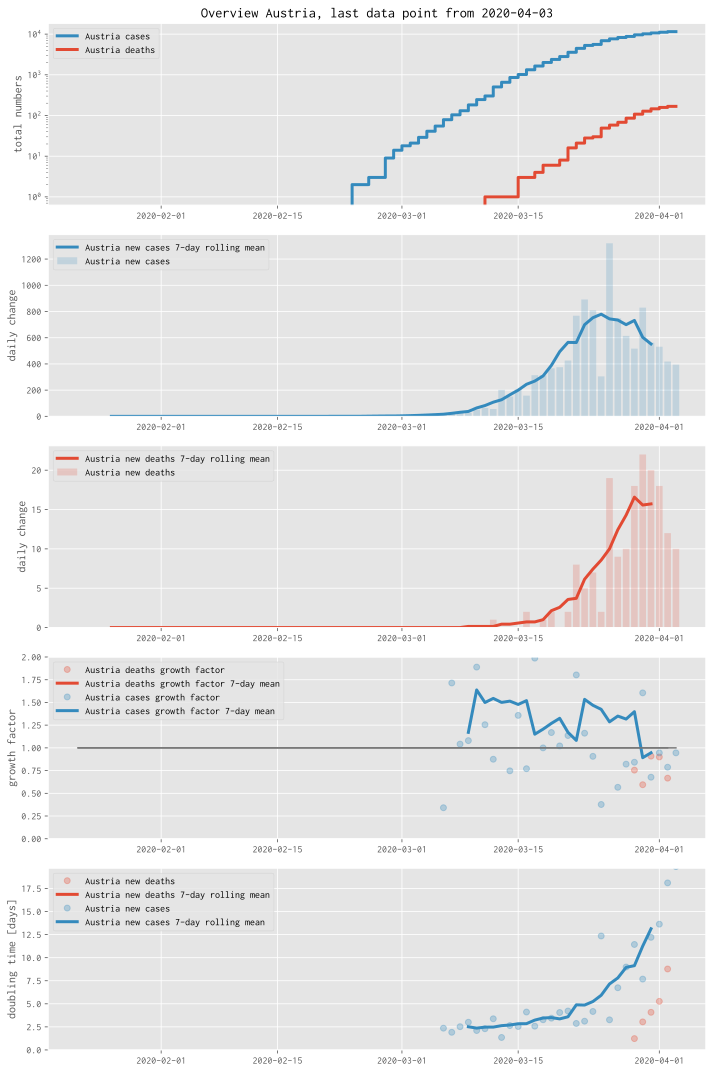

In [13]:
overview("Austria");